### Park 1 Sensor 2 LEFT

In [ ]:
#!pip install opencv-python
#!pip install yolov5
#!pip install filterpy
#!pip install ultralytics


In [ ]:
import cv2
import numpy as np
from datetime import datetime
from ultralytics import YOLO
#from sort.sort import Sort
from sort import Sort
import os
from google.colab.patches import cv2_imshow
from collections import Counter
import pandas as pd


tracker = Sort()
model = YOLO("yolov8n.pt")

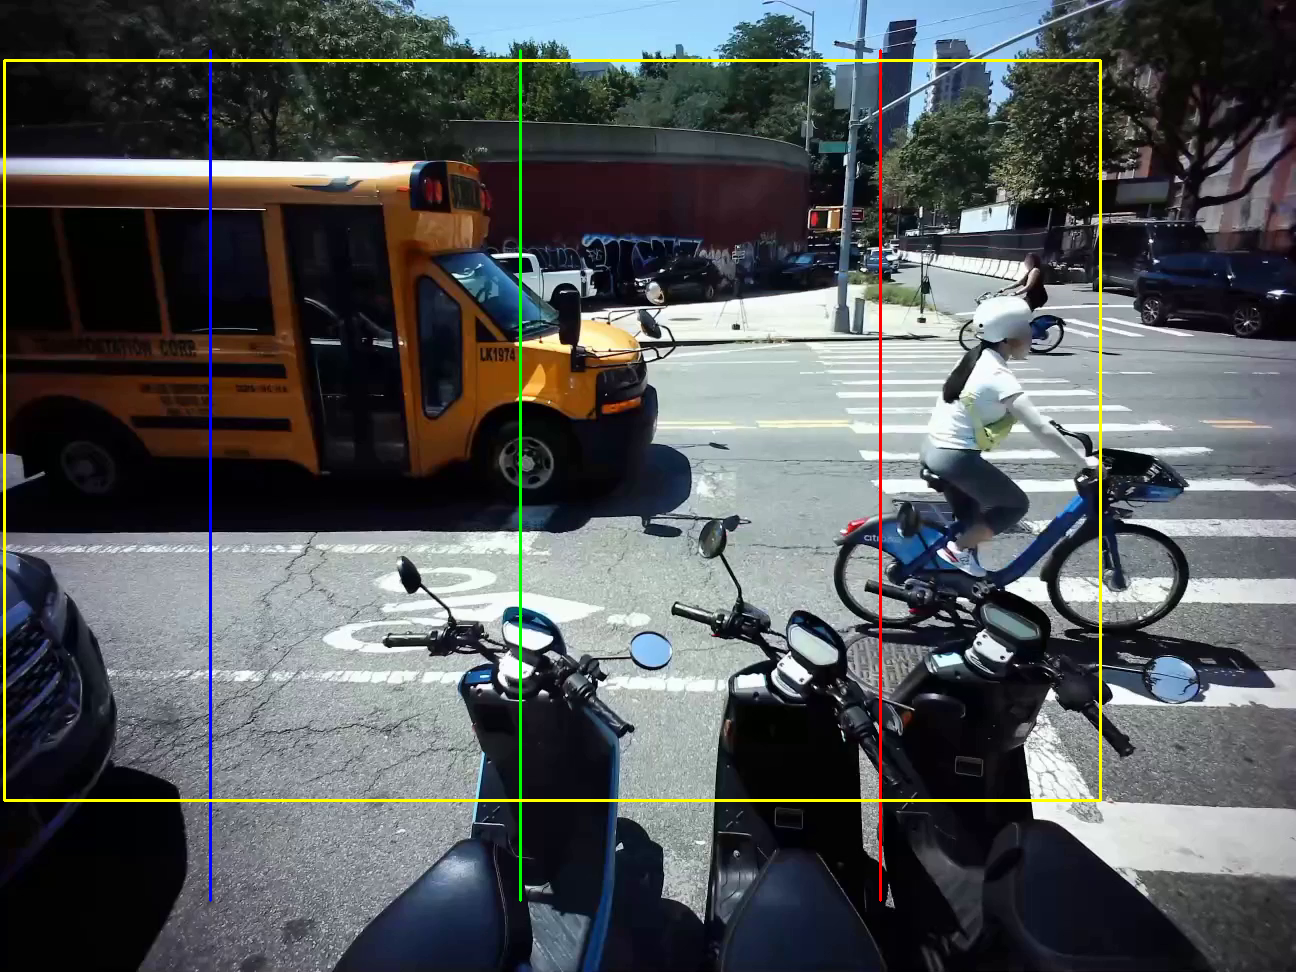

In [ ]:
# preview lines

# BLUE_LINE = [(285, 430), (70, 670)]
# GREEN_LINE = [(590, 430), (400, 690)]
# RED_LINE = [(900, 430), (760, 690)]

BLUE_LINE = [(210, 50), (210, 900)]
GREEN_LINE = [(520, 50), (520, 900)]
RED_LINE = [(880, 50), (880, 900)]


pts_right = np.array([[[4, 60], [4, 800], [1100, 800], [1100, 60]]])


if __name__ == '__main__':
    cap = cv2.VideoCapture("left_half_10min.mp4")
    #cap = cv2.VideoCapture("left_half_10min_short5.mp4")

    while cap.isOpened():
        status, frame = cap.read()

        if not status:
            break

        results = model(frame, stream=True)

        cv2.line(frame, BLUE_LINE[0], BLUE_LINE[1], (255, 0, 0), 2)
        cv2.line(frame, GREEN_LINE[0], GREEN_LINE[1], (0, 255, 0), 2)
        cv2.line(frame, RED_LINE[0], RED_LINE[1], (0, 0, 255), 2)


        cv2.polylines(frame, [pts_right], isClosed=True, color=(0, 255, 255), thickness=2)

        #cv2.imshow("frame", frame)
        cv2_imshow(frame)

        break

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()

In [ ]:
# check video fps
cap = cv2.VideoCapture("left_half_10min.mp4")
VIDEO_FPS = cap.get(cv2.CAP_PROP_FPS)
print(f"Video FPS: {VIDEO_FPS}")
cap.release()


Video FPS: 14.40299572039943


In [ ]:
PIXELS_PER_METER = 163.6
METERS_PER_PIXEL = 1 / PIXELS_PER_METER
SPEED_CONVERSION_FACTOR = METERS_PER_PIXEL * VIDEO_FPS * 3600 / 1000  # convert m/s to km/h
print(f"Conversion Factor: {SPEED_CONVERSION_FACTOR} km/h per pixel/frame")


Conversion Factor: 0.31693633614570876 km/h per pixel/frame


Setting Lines and Variables

In [ ]:
BLUE_LINE = [(210, 50), (210, 900)]
GREEN_LINE = [(520, 50), (520, 900)]
RED_LINE = [(880, 50), (880, 900)]

cross_blue_line = {}
cross_green_line = {}
cross_red_line = {}


avg_speeds = {}

VIDEO_FPS = 14.40
FACTOR_KM = 0.317
LATENCY_FPS = 7

Euclidean Distance Function

In [ ]:
def euclidean_distance(point1: tuple, point2: tuple):
    x1, y1 = point1
    x2, y2 = point2
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

Speed Calculation on the Right Side of the Road

In [ ]:
def calculate_avg_speed_right(track_id):
    time_bg = (cross_green_line[track_id]["time"] - cross_blue_line[track_id]["time"]).total_seconds()
    time_gr = (cross_red_line[track_id]["time"] - cross_green_line[track_id]["time"]).total_seconds()
    total_time = (time_bg + time_gr) / 2

    distance_bg = euclidean_distance(cross_green_line[track_id]["point"], cross_blue_line[track_id]["point"])
    distance_gr = euclidean_distance(cross_red_line[track_id]["point"], cross_green_line[track_id]["point"])

    speed_bg = round((distance_bg / (time_bg * VIDEO_FPS)) * (FACTOR_KM * LATENCY_FPS), 2) * 0.621371  # km/hr to mph
    speed_gr = round((distance_gr / (time_gr * VIDEO_FPS)) * (FACTOR_KM * LATENCY_FPS), 2) * 0.621371

    acceleration = (speed_gr - speed_bg) / total_time if total_time > 0 else 0

    return round(speed_bg, 2), round(speed_gr, 2), round((speed_bg + speed_gr) / 2, 2), round(acceleration, 2)

## Speed Detection

### without pts_right, use entire frame

In [ ]:
# calculated_speeds = set()

# video_path = "left_half_10min_short6.mp4"
# video_path_out = '0502_short_out6.webm'


# cap = cv2.VideoCapture(video_path)
# ret, frame = cap.read()
# H, W, _ = frame.shape
# out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'vp80'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

# speed_results = []

# class_map = {
#     1: "Bicycle",
#     2: "Car",
#     3: "Motorcycle",
#     5: "Bus",
#     7: "Truck"
# }


# while ret:
#     results = model(frame, stream=True)
#     for res in results:
#         filtered_indices = np.where((np.isin(res.boxes.cls.cpu().numpy(), [1, 2, 3, 5, 7])) & (res.boxes.conf.cpu().numpy() > 0.05))[0]
#         boxes = res.boxes.xyxy.cpu().numpy()[filtered_indices].astype(int)
#         class_ids = res.boxes.cls.cpu().numpy()[filtered_indices]

#         tracks = tracker.update(boxes)
#         for i, (xmin, ymin, xmax, ymax, track_id) in enumerate(tracks):

#             xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
#             xc, yc = int((xmin + xmax) / 2), ymax

#             if track_id not in cross_blue_line:
#                 cross_blue = (xc - BLUE_LINE[0][0])
#                 if cross_blue >= 0:
#                     cross_blue_line[track_id] = {"time": datetime.now(), "point": (xc, yc)}

#             if track_id in cross_blue_line and track_id not in cross_green_line:
#                 cross_green = (xc - GREEN_LINE[0][0])
#                 if cross_green >= 0:
#                     cross_green_line[track_id] = {"time": datetime.now(), "point": (xc, yc)}

#             if track_id in cross_green_line and track_id not in cross_red_line:
#                 cross_red = (xc - RED_LINE[0][0])
#                 if cross_red >= 0:
#                     cross_red_line[track_id] = {"time": datetime.now(), "point": (xc, yc)}

#             if track_id in cross_blue_line and track_id in cross_green_line and track_id in cross_red_line:
#                 if track_id not in calculated_speeds:
#                     calculated_speeds.add(track_id)
#                     speed_bg, speed_gr, avg_speed, acc = calculate_avg_speed_right(track_id)
#                     speed_results.append([int(track_id), class_map.get(class_ids[i], "Unknown"), speed_bg, speed_gr, avg_speed, acc])

#                     # display avg_speed > 0
#                     # all vehicles not crossing blue line, green line, and then red line will have speed = 0
#                     if avg_speed > 0.1:
#                         text_x = xmin
#                         text_y = max(10, ymin - 10)
#                         cv2.putText(frame, f"ID {track_id}({class_map[class_ids[i]]}): {avg_speed:.2f} mph", (text_x, text_y), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 3)


#             cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)

#         cv2.line(frame, BLUE_LINE[0], BLUE_LINE[1], (255, 0, 0), 2)
#         cv2.line(frame, GREEN_LINE[0], GREEN_LINE[1], (0, 255, 0), 2)
#         cv2.line(frame, RED_LINE[0], RED_LINE[1], (0, 0, 255), 2)

#     out.write(frame)
#     ret, frame = cap.read()

#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cap.release()
# out.release()
# cv2.destroyAllWindows()


In [ ]:
# speed_results

### with pts_right frame

In [ ]:
calculated_speeds = set()

video_path = "left_half_10min.mp4"
video_path_out = '0502_10min_out.webm'

cap = cv2.VideoCapture(video_path)

# Read the first frame to get dimensions
ret, frame = cap.read()
H, W, _ = frame.shape

# Define the detection area mask
pts_right = np.array([[[4, 60], [4, 800], [1100, 800], [1100, 60]]])
mask_right = np.zeros((H, W), dtype=np.uint8)
cv2.fillPoly(mask_right, [pts_right], 255)


out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'vp80'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))
speed_results = []
unique_vehicle_ids = set()

class_map = {
    1: "Bicycle",
    2: "Car",
    3: "Motorcycle",
    5: "Bus",
    7: "Truck"
}


while ret:
    right_zone = cv2.bitwise_and(frame, frame, mask=mask_right)
    results = model(right_zone, stream=True)

    for res in results:
        filtered_indices = np.where((np.isin(res.boxes.cls.cpu().numpy(), [1, 2, 3, 5, 7])) & (res.boxes.conf.cpu().numpy() > 0.05))[0]
        boxes = res.boxes.xyxy.cpu().numpy()[filtered_indices].astype(int)
        class_ids = res.boxes.cls.cpu().numpy()[filtered_indices]

        tracks = tracker.update(boxes)
        for i, (xmin, ymin, xmax, ymax, track_id) in enumerate(tracks):

            xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
            xc, yc = int((xmin + xmax) / 2), ymax

            if track_id not in cross_blue_line:
                cross_blue = (xc - BLUE_LINE[0][0])
                if cross_blue >= 0:
                    cross_blue_line[track_id] = {"time": datetime.now(), "point": (xc, yc)}

            if track_id in cross_blue_line and track_id not in cross_green_line:
                cross_green = (xc - GREEN_LINE[0][0])
                if cross_green >= 0:
                    cross_green_line[track_id] = {"time": datetime.now(), "point": (xc, yc)}

            if track_id in cross_green_line and track_id not in cross_red_line:
                cross_red = (xc - RED_LINE[0][0])
                if cross_red >= 0:
                    cross_red_line[track_id] = {"time": datetime.now(), "point": (xc, yc)}

            if track_id in cross_blue_line and track_id in cross_green_line and track_id in cross_red_line:
                if track_id not in calculated_speeds:
                    calculated_speeds.add(track_id)
                    speed_bg, speed_gr, avg_speed, acc = calculate_avg_speed_right(track_id)
                    speed_results.append([int(track_id), class_map.get(class_ids[i], "Unknown"), speed_bg, speed_gr, avg_speed, acc])

                    # display avg_speed > 0
                    # all vehicles not crossing blue line, green line, and then red line will have speed = 0
                    if avg_speed > 0.1:
                        text_x = xmin
                        text_y = max(10, ymin - 10)
                        cv2.putText(frame, f"ID {track_id}({class_map[class_ids[i]]}): {avg_speed:.2f} mph", (text_x, text_y), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 255), 3)


            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (255, 255, 0), 2)

        cv2.line(frame, BLUE_LINE[0], BLUE_LINE[1], (255, 0, 0), 2)
        cv2.line(frame, GREEN_LINE[0], GREEN_LINE[1], (0, 255, 0), 2)
        cv2.line(frame, RED_LINE[0], RED_LINE[1], (0, 0, 255), 2)

    out.write(frame)
    ret, frame = cap.read()

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


Streaming output truncated to the last 5000 lines.
0: 480x640 1 person, 6 cars, 2 motorcycles, 159.7ms
Speed: 5.6ms preprocess, 159.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 2 motorcycles, 163.3ms
Speed: 7.6ms preprocess, 163.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 7 cars, 2 motorcycles, 177.3ms
Speed: 5.0ms preprocess, 177.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 2 motorcycles, 157.6ms
Speed: 4.3ms preprocess, 157.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 2 motorcycles, 160.9ms
Speed: 6.6ms preprocess, 160.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 6 cars, 3 motorcycles, 155.8ms
Speed: 5.6ms preprocess, 155.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6 cars, 2 motorcycles, 261.5ms
Speed: 4.5ms preprocess, 261.5ms inferenc

In [ ]:
speed_results

[[7, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1, 'Car', 0.0, 0.0, 0.0, 0.0],
 [9, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [8, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2, 'Car', 0.0, 1.71, 0.86, 3.05],
 [15, 'Motorcycle', 0.0, 0.17, 0.09, 0.28],
 [33, 'Car', 0.0, 5.07, 2.54, 5.8],
 [40, 'Car', 0.0, 0.0, 0.0, 0.0],
 [44, 'Car', 0.0, 0.0, 0.0, 0.0],
 [48, 'Car', 0.0, 0.0, 0.0, 0.0],
 [54, 'Car', 0.0, 0.0, 0.0, 0.0],
 [34, 'Motorcycle', 6.28, 9.18, 7.73, 0.68],
 [64, 'Car', 0.0, 0.0, 0.0, 0.0],
 [66, 'Car', 0.0, 0.0, 0.0, 0.0],
 [68, 'Car', 8.43, 10.87, 9.65, 0.73],
 [95, 'Car', 0.0, 0.0, 0.0, 0.0],
 [100, 'Car', 0.0, 0.0, 0.0, 0.0],
 [103, 'Car', 0.0, 0.0, 0.0, 0.0],
 [109, 'Car', 0.0, 0.0, 0.0, 0.0],
 [126, 'Car', 0.0, 0.0, 0.0, 0.0],
 [127, 'Car', 0.0, 0.0, 0.0, 0.0],
 [125, 'Motorcycle', 12.2, 10.31, 11.26, -0.65],
 [154, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [164, 'Motorcycle', 0.0, 9.36, 4.68, 10.6],
 [173, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [175, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [176, 'Motorcycle'

## Result & Output

In [ ]:
speed_results_copy = [[7, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1, 'Car', 0.0, 0.0, 0.0, 0.0],
 [9, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [8, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2, 'Car', 0.0, 1.71, 0.86, 3.05],
 [15, 'Motorcycle', 0.0, 0.17, 0.09, 0.28],
 [33, 'Car', 0.0, 5.07, 2.54, 5.8],
 [40, 'Car', 0.0, 0.0, 0.0, 0.0],
 [44, 'Car', 0.0, 0.0, 0.0, 0.0],
 [48, 'Car', 0.0, 0.0, 0.0, 0.0],
 [54, 'Car', 0.0, 0.0, 0.0, 0.0],
 [34, 'Motorcycle', 6.28, 9.18, 7.73, 0.68],
 [64, 'Car', 0.0, 0.0, 0.0, 0.0],
 [66, 'Car', 0.0, 0.0, 0.0, 0.0],
 [68, 'Car', 8.43, 10.87, 9.65, 0.73],
 [95, 'Car', 0.0, 0.0, 0.0, 0.0],
 [100, 'Car', 0.0, 0.0, 0.0, 0.0],
 [103, 'Car', 0.0, 0.0, 0.0, 0.0],
 [109, 'Car', 0.0, 0.0, 0.0, 0.0],
 [126, 'Car', 0.0, 0.0, 0.0, 0.0],
 [127, 'Car', 0.0, 0.0, 0.0, 0.0],
 [125, 'Motorcycle', 12.2, 10.31, 11.26, -0.65],
 [154, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [164, 'Motorcycle', 0.0, 9.36, 4.68, 10.6],
 [173, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [175, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [176, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [185, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [186, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [192, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [197, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [201, 'Car', 0.0, 0.07, 0.04, 0.03],
 [207, 'Motorcycle', 30.3, 30.86, 30.58, 0.58],
 [216, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [226, 'Car', 0.0, 0.0, 0.0, 0.0],
 [220, 'Motorcycle', 11.68, 17.27, 14.47, 2.43],
 [234, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [232, 'Car', 0.0, 0.02, 0.01, 0.0],
 [249, 'Car', 0.0, 0.0, 0.0, 0.0],
 [252, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [256, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [261, 'Car', 0.0, 0.0, 0.0, 0.0],
 [267, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [269, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [276, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [278, 'Motorcycle', 0.0, 0.32, 0.16, 2.2],
 [287, 'Motorcycle', 0.0, 0.07, 0.03, 0.1],
 [292, 'Car', 0.0, 0.0, 0.0, 0.0],
 [297, 'Car', 0.0, 0.0, 0.0, 0.0],
 [315, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [316, 'Car', 0.0, 0.02, 0.01, 0.01],
 [323, 'Car', 0.0, 0.0, 0.0, 0.0],
 [324, 'Car', 0.0, 0.0, 0.0, 0.0],
 [326, 'Car', 0.0, 0.0, 0.0, 0.0],
 [327, 'Car', 0.0, 0.0, 0.0, 0.0],
 [331, 'Car', 0.0, 0.0, 0.0, 0.0],
 [330, 'Car', 0.0, 0.19, 0.1, 0.55],
 [332, 'Car', 0.0, 0.0, 0.0, 0.0],
 [333, 'Car', 0.0, 0.0, 0.0, 0.0],
 [336, 'Car', 0.0, 0.32, 0.16, 2.12],
 [357, 'Car', 0.0, 0.06, 0.03, 0.04],
 [366, 'Car', 0.0, 0.0, 0.0, 0.0],
 [381, 'Car', 0.0, 0.0, 0.0, 0.0],
 [391, 'Car', 0.0, 0.0, 0.0, 0.0],
 [392, 'Car', 0.0, 0.0, 0.0, 0.0],
 [422, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [419, 'Car', 0.0, 0.0, 0.0, 0.0],
 [417, 'Car', 0.0, 7.7, 3.85, 6.42],
 [441, 'Car', 0.0, 0.0, 0.0, 0.0],
 [432, 'Truck', 8.03, 12.82, 10.42, 1.44],
 [466, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [472, 'Car', 0.0, 0.0, 0.0, 0.0],
 [480, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [481, 'Motorcycle', 10.86, 13.91, 12.38, 1.15],
 [504, 'Car', 0.0, 0.0, 0.0, 0.0],
 [507, 'Car', 12.4, 11.15, 11.77, -0.45],
 [538, 'Bicycle', 0.0, 0.0, 0.0, 0.0],
 [541, 'Bicycle', 0.0, 0.0, 0.0, 0.0],
 [542, 'Motorcycle', 0.0, 20.93, 10.47, 127.13],
 [552, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [555, 'Car', 0.0, 0.0, 0.0, 0.0],
 [558, 'Car', 16.07, 18.72, 17.4, 1.44],
 [574, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [564, 'Car', 0.0, 0.06, 0.03, 0.03],
 [578, 'Car', 0.0, 0.0, 0.0, 0.0],
 [581, 'Car', 0.0, 0.0, 0.0, 0.0],
 [584, 'Car', 0.0, 0.0, 0.0, 0.0],
 [587, 'Car', 0.0, 0.0, 0.0, 0.0],
 [594, 'Car', 0.0, 0.22, 0.11, 0.47],
 [597, 'Car', 0.0, 0.0, 0.0, 0.0],
 [603, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [605, 'Car', 0.0, 0.0, 0.0, 0.0],
 [609, 'Car', 0.0, 0.0, 0.0, 0.0],
 [615, 'Bicycle', 0.0, 0.0, 0.0, 0.0],
 [616, 'Car', 0.0, 0.0, 0.0, 0.0],
 [619, 'Bicycle', 0.0, 0.0, 0.0, 0.0],
 [618, 'Car', 0.0, 0.0, 0.0, 0.0],
 [622, 'Car', 0.0, 0.0, 0.0, 0.0],
 [610, 'Car', 17.17, 19.7, 18.44, 1.45],
 [628, 'Car', 0.0, 0.0, 0.0, 0.0],
 [632, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [635, 'Car', 0.0, 0.0, 0.0, 0.0],
 [643, 'Car', 0.0, 0.0, 0.0, 0.0],
 [645, 'Car', 0.0, 0.0, 0.0, 0.0],
 [637, 'Car', 15.75, 18.27, 17.01, 1.28],
 [651, 'Car', 0.0, 0.0, 0.0, 0.0],
 [656, 'Car', 0.0, 0.0, 0.0, 0.0],
 [655, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [664, 'Car', 17.41, 17.69, 17.55, 0.15],
 [673, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [672, 'Car', 0.0, 0.0, 0.0, 0.0],
 [690, 'Car', 8.39, 5.64, 7.02, -0.58],
 [705, 'Car', 0.0, 0.0, 0.0, 0.0],
 [706, 'Car', 0.0, 0.0, 0.0, 0.0],
 [703, 'Car', 0.0, 0.17, 0.08, 0.3],
 [707, 'Car', 0.0, 0.0, 0.0, 0.0],
 [700, 'Motorcycle', 10.23, 10.65, 10.44, 0.14],
 [735, 'Car', 0.0, 0.0, 0.0, 0.0],
 [739, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [740, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [741, 'Car', 0.0, 0.0, 0.0, 0.0],
 [742, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [754, 'Car', 0.0, 0.0, 0.0, 0.0],
 [745, 'Car', 15.68, 11.78, 13.73, -1.73],
 [766, 'Car', 0.0, 0.0, 0.0, 0.0],
 [768, 'Car', 0.0, 0.0, 0.0, 0.0],
 [769, 'Car', 0.0, 0.0, 0.0, 0.0],
 [772, 'Car', 0.0, 0.22, 0.11, 0.7],
 [786, 'Car', 0.0, 0.0, 0.0, 0.0],
 [791, 'Car', 0.0, 0.0, 0.0, 0.0],
 [818, 'Car', 0.0, 0.0, 0.0, 0.0],
 [885, 'Car', 0.0, 0.0, 0.0, 0.0],
 [897, 'Car', 0.0, 0.35, 0.17, 2.51],
 [899, 'Car', 0.0, 0.0, 0.0, 0.0],
 [905, 'Car', 0.0, 0.0, 0.0, 0.0],
 [789, 'Motorcycle', 2.63, 0.18, 1.41, -0.02],
 [936, 'Car', 0.0, 0.02, 0.01, 0.01],
 [943, 'Car', 0.0, 0.0, 0.0, 0.0],
 [922, 'Car', 4.39, 6.06, 5.23, 0.27],
 [960, 'Car', 13.3, 23.22, 18.26, 6.36],
 [969, 'Car', 0.0, 0.0, 0.0, 0.0],
 [949, 'Motorcycle', 5.8, 9.36, 7.58, 0.81],
 [975, 'Car', 0.0, 0.0, 0.0, 0.0],
 [976, 'Motorcycle', 7.93, 12.53, 10.23, 1.41],
 [1001, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1023, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1032, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1033, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1034, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1027, 'Truck', 9.05, 14.07, 11.56, 1.71],
 [1047, 'Motorcycle', 10.64, 15.8, 13.22, 2.01],
 [1088, 'Car', 0.0, 7.34, 3.67, 3.14],
 [1096, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1100, 'Motorcycle', 0.0, 0.48, 0.24, 3.38],
 [1105, 'Car', 12.83, 15.1, 13.97, 0.97],
 [1122, 'Car', 13.5, 14.89, 14.2, 0.59],
 [1126, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1131, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1130, 'Motorcycle', 9.16, 10.5, 9.83, 0.39],
 [1146, 'Car', 0.0, 0.05, 0.02, 0.05],
 [1153, 'Car', 10.66, 11.53, 11.09, 0.29],
 [1166, 'Motorcycle', 10.33, 10.51, 10.42, 0.06],
 [1178, 'Car', 0.0, 0.03, 0.02, 0.02],
 [1197, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1206, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1202, 'Motorcycle', 14.67, 15.39, 15.03, 0.34],
 [1213, 'Car', 8.95, 13.35, 11.15, 1.43],
 [1230, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1237, 'Motorcycle', 0.0, 0.02, 0.01, 0.01],
 [1241, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1243, 'Car', 0.0, 0.16, 0.08, 0.28],
 [1244, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1246, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1245, 'Motorcycle', 0.0, 0.22, 0.11, 0.27],
 [1254, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1272, 'Car', 0.0, 0.12, 0.06, 0.3],
 [1275, 'Car', 0.0, 0.07, 0.03, 0.07],
 [1283, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1289, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1299, 'Car', 0.0, 0.22, 0.11, 0.45],
 [1303, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1235, 'Motorcycle', 0.34, 0.4, 0.37, 0.0],
 [1331, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1343, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1341, 'Bus', 3.59, 4.96, 4.28, 0.25],
 [1360, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1359, 'Motorcycle', 10.04, 12.81, 11.42, 0.99],
 [1389, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1393, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1388, 'Truck', 10.67, 14.08, 12.37, 1.28],
 [1411, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1414, 'Car', 13.98, 17.06, 15.52, 1.46],
 [1432, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1442, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1434, 'Motorcycle', 11.09, 16.91, 14.0, 2.46],
 [1446, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1448, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1457, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1461, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1468, 'Bicycle', 29.25, 25.35, 27.3, -4.8],
 [1481, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1478, 'Car', 19.97, 17.48, 18.73, -1.46],
 [1488, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1490, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1501, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1512, 'Motorcycle', 18.03, 21.91, 19.97, 2.39],
 [1527, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1531, 'Truck', 0.0, 14.66, 7.33, 39.97],
 [1542, 'Motorcycle', 0.0, 0.14, 0.07, 0.11],
 [1545, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1548, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1547, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1551, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1550, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1584, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1583, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1589, 'Car', 0.0, 0.04, 0.02, 0.01],
 [1593, 'Motorcycle', 37.98, 36.05, 37.02, -2.75],
 [1602, 'Car', 0.0, 0.35, 0.18, 2.61],
 [1611, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1615, 'Car', 0.0, 0.16, 0.08, 0.15],
 [1631, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1624, 'Motorcycle', 12.37, 13.33, 12.85, 0.38],
 [1634, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1635, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1646, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1648, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1644, 'Car', 0.0, 0.07, 0.04, 0.04],
 [1655, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1656, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1658, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1662, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1684, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1687, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1689, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1709, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1714, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1716, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1718, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1722, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1741, 'Car', 0.0, 0.09, 0.04, 0.11],
 [1756, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1758, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1767, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1773, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1782, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1786, 'Car', 0.0, 0.29, 0.14, 1.7],
 [1690, 'Car', 0.24, 8.05, 4.14, 0.12],
 [1796, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1801, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1814, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1817, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1811, 'Car', 6.7, 11.46, 9.08, 1.24],
 [1840, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1841, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1847, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1845, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1848, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1856, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1860, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1851, 'Car', 10.29, 13.67, 11.98, 1.27],
 [1887, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1888, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1902, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1903, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1906, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1911, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1910, 'Motorcycle', 17.9, 19.96, 18.93, 1.27],
 [1917, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1919, 'Truck', 0.0, 0.0, 0.0, 0.0],
 [1926, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1931, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1932, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1975, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1971, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1969, 'Car', 0.0, 0.0, 0.0, 0.0],
 [1976, 'Motorcycle', 18.55, 21.28, 19.91, 1.62],
 [1988, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1989, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [1990, 'Car', 35.36, 32.93, 34.14, -3.53],
 [2012, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2021, 'Motorcycle', 0.0, 12.38, 6.19, 38.96],
 [2027, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2031, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2049, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2054, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2057, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2065, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2069, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2071, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2130, 'Car', 0.0, 0.31, 0.16, 2.02],
 [2149, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2168, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2177, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2193, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2201, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2202, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2205, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2214, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2219, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2232, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2238, 'Car', 0.0, 0.02, 0.01, 0.01],
 [2253, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2289, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2288, 'Car', 0.96, 4.92, 2.94, 0.33],
 [2311, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2304, 'Motorcycle', 5.4, 8.67, 7.04, 0.68],
 [2343, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2334, 'Car', 9.29, 12.45, 10.87, 1.06],
 [2363, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2394, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2415, 'Car', 11.98, 13.53, 12.75, 0.61],
 [2426, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2429, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2453, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2460, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2464, 'Car', 14.11, 15.2, 14.66, 0.49],
 [2477, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2491, 'Car', 13.61, 11.73, 12.67, -0.71],
 [2507, 'Motorcycle', 27.92, 25.36, 26.64, -2.4],
 [2518, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2524, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2526, 'Car', 0.0, 0.01, 0.0, 0.0],
 [2533, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2539, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2541, 'Motorcycle', 25.01, 28.69, 26.85, 2.84],
 [2562, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2580, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2582, 'Car', 0.0, 0.11, 0.05, 0.11],
 [2587, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2600, 'Car', 0.0, 0.32, 0.16, 2.2],
 [2599, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2603, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2608, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2623, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2632, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2642, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2648, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2647, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2674, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2670, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2667, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2681, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2677, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2676, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2695, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2696, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2699, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2694, 'Car', 0.0, 0.06, 0.03, 0.02],
 [2708, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2675, 'Car', 0.59, 8.16, 4.38, 0.28],
 [2727, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2732, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2723, 'Motorcycle', 5.69, 8.87, 7.28, 0.69],
 [2741, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2743, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2750, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2754, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2739, 'Car', 6.23, 9.38, 7.8, 0.72],
 [2765, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2768, 'Car', 0.0, 0.19, 0.09, 0.52],
 [2777, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2761, 'Car', 7.18, 10.96, 9.07, 1.0],
 [2787, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2789, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2788, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2796, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2806, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2795, 'Motorcycle', 10.54, 13.82, 12.18, 1.2],
 [2823, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2824, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2831, 'Car', 0.0, 0.07, 0.03, 0.1],
 [2837, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2835, 'Car', 16.56, 16.74, 16.65, 0.09],
 [2848, 'Car', 0.0, 0.13, 0.07, 0.36],
 [2854, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2855, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2876, 'Car', 25.94, 29.19, 27.56, 2.63],
 [2875, 'Car', 0.0, 0.02, 0.01, 0.01],
 [2895, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2891, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2900, 'Car', 0.0, 0.04, 0.02, 0.02],
 [2952, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2949, 'Motorcycle', 0.0, 0.0, 0.0, 0.0],
 [2964, 'Car', 26.41, 27.15, 26.78, 0.69],
 [2970, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2972, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2975, 'Car', 14.02, 17.38, 15.7, 1.59],
 [2984, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2986, 'Car', 0.0, 0.0, 0.0, 0.0],
 [2997, 'Car', 0.0, 0.0, 0.0, 0.0]]

In [ ]:
len(speed_results_copy)

391

In [ ]:
def lane_correction(speed_results, threshold = 0.1):
  # [vehicle_id, vehicle_type, speed_bg, speed_gr, avg_speed, acceleration]
  # only include entries with speed > threshold (moving vehicles)
  #filtered = [entry for entry in speed_results
              #if float(entry[2]) > threshold and float(entry[3]) > threshold and float(entry[4]) > threshold]

  filtered = [entry for entry in speed_results if float(entry[4]) > threshold]

  return filtered


def report_results(results_arr):
  ## total vehicles
  print("Total vehicles identified:", len(results_arr))
  print()

  ## vehicle type counts
  vehicle_types = [v[1] for v in results_arr]
  type_counts = Counter(vehicle_types)
  print("Count of vehicle IDs for each type:")
  for type_name, count in type_counts.items():
      print(f"Type {type_name}: {count} vehicle(s)")
  print()

  ## speeding
  speed_limit = 25

  speed_results_array = np.array(results_arr)
  avg_speeds = speed_results_array[:, 4].astype(float)

  # Count the number of cars exceeding the speed limit
  overspeed_count = np.sum(avg_speeds > speed_limit)
  reckless_driving_count = np.sum(avg_speeds > (speed_limit+30))

  # Total number of cars identified (assumed to be the length of the speed_results array)
  total_cars = len(speed_results_array)

  # Calculate the percentage of cars that are overspeeding
  overspeed_percentage = (overspeed_count / total_cars) * 100

  print("NYC speed limit: 25 mph (40.2 km/h)")
  print(f"Total vehicles identified with speed: {total_cars}")
  print(f"Total vehicles overspeeding: {overspeed_count}")
  print(f"Percentage of vehicles overspeeding: {overspeed_percentage:.2f}%")
  print(f"Percentage of vehicles reckless_driving: {overspeed_percentage:.2f}%")


-----------

**Updated Part**

In [ ]:
lane_results = lane_correction(speed_results_copy, 0.03)
len(lane_results)

96

In [ ]:
import cv2
import numpy as np
from datetime import datetime
from collections import Counter
import pandas as pd

In [ ]:
report_results(lane_results)

Total vehicles identified: 102

Count of vehicle IDs for each type:
Type Car: 61 vehicle(s)
Type Motorcycle: 35 vehicle(s)
Type Truck: 4 vehicle(s)
Type Bus: 1 vehicle(s)
Type Bicycle: 1 vehicle(s)

NYC speed limit: 25 mph (40.2 km/h)
Total vehicles identified with speed: 102
Total vehicles overspeeding: 8
Percentage of vehicles overspeeding: 7.84%
Percentage of vehicles reckless_driving: 7.84%


In [ ]:
all_detected = pd.DataFrame(speed_results_copy, columns = ['VehicleID', 'Type', 'SpeedBG', 'SpeedGR', 'AvgSpeed', 'Acceleration'])
all_detected

,VehicleID,Type,SpeedBG,SpeedGR,AvgSpeed,Acceleration
0,7,Motorcycle,0.00,0.00,0.00,0.00
1,1,Car,0.00,0.00,0.00,0.00
2,9,Truck,0.00,0.00,0.00,0.00
3,8,Motorcycle,0.00,0.00,0.00,0.00
4,2,Car,0.00,1.71,0.86,3.05
...,...,...,...,...,...,...
386,2972,Car,0.00,0.00,0.00,0.00
387,2975,Car,14.02,17.38,15.70,1.59
388,2984,Car,0.00,0.00,0.00,0.00
389,2986,Car,0.00,0.00,0.00,0.00


In [ ]:
all_detected.to_csv('all_detected_vehicles.csv', index=False)

---------------

In [ ]:
len(speed_results)

391

In [ ]:
lane_results = lane_correction(speed_results, 0.2)
lane_results

[[34, 'Motorcycle', 6.28, 9.18, 7.73, 0.68],
 [68, 'Car', 8.43, 10.87, 9.65, 0.73],
 [125, 'Motorcycle', 12.2, 10.31, 11.26, -0.65],
 [207, 'Motorcycle', 30.3, 30.86, 30.58, 0.58],
 [220, 'Motorcycle', 11.68, 17.27, 14.47, 2.43],
 [432, 'Truck', 8.03, 12.82, 10.42, 1.44],
 [481, 'Motorcycle', 10.86, 13.91, 12.38, 1.15],
 [507, 'Car', 12.4, 11.15, 11.77, -0.45],
 [558, 'Car', 16.07, 18.72, 17.4, 1.44],
 [610, 'Car', 17.17, 19.7, 18.44, 1.45],
 [637, 'Car', 15.75, 18.27, 17.01, 1.28],
 [664, 'Car', 17.41, 17.69, 17.55, 0.15],
 [690, 'Car', 8.39, 5.64, 7.02, -0.58],
 [700, 'Motorcycle', 10.23, 10.65, 10.44, 0.14],
 [745, 'Car', 15.68, 11.78, 13.73, -1.73],
 [922, 'Car', 4.39, 6.06, 5.23, 0.27],
 [960, 'Car', 13.3, 23.22, 18.26, 6.36],
 [949, 'Motorcycle', 5.8, 9.36, 7.58, 0.81],
 [976, 'Motorcycle', 7.93, 12.53, 10.23, 1.41],
 [1027, 'Truck', 9.05, 14.07, 11.56, 1.71],
 [1047, 'Motorcycle', 10.64, 15.8, 13.22, 2.01],
 [1105, 'Car', 12.83, 15.1, 13.97, 0.97],
 [1122, 'Car', 13.5, 14.89, 14

In [ ]:
len(lane_results)

62

In [ ]:
report_results(lane_results)

Total vehicles identified: 62

Count of vehicle IDs for each type:
Type Motorcycle: 25 vehicle(s)
Type Car: 32 vehicle(s)
Type Truck: 3 vehicle(s)
Type Bus: 1 vehicle(s)
Type Bicycle: 1 vehicle(s)

NYC speed limit: 25 mph (40.2 km/h)
Total vehicles identified with speed: 62
Total vehicles overspeeding: 8
Percentage of vehicles overspeeding: 12.90%
Percentage of vehicles reckless_driving: 12.90%


In [ ]:
output_df = pd.DataFrame(lane_results, columns = ['VehicleID', 'Type', 'SpeedBG', 'SpeedGR', 'AvgSpeed', 'Acceleration'])
output_df

,VehicleID,Type,SpeedBG,SpeedGR,AvgSpeed,Acceleration
0,34,Motorcycle,6.28,9.18,7.73,0.68
1,68,Car,8.43,10.87,9.65,0.73
2,125,Motorcycle,12.20,10.31,11.26,-0.65
3,207,Motorcycle,30.30,30.86,30.58,0.58
4,220,Motorcycle,11.68,17.27,14.47,2.43
...,...,...,...,...,...,...
57,2795,Motorcycle,10.54,13.82,12.18,1.20
58,2835,Car,16.56,16.74,16.65,0.09
59,2876,Car,25.94,29.19,27.56,2.63
60,2964,Car,26.41,27.15,26.78,0.69


In [ ]:
output_df.to_csv('vehicle_speeds.csv', index=False)